In [1]:
from coffea import hist
import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import random
plt.style.use(hep.style.CMS)

import awkward as ak

from matplotlib import colors
POPTS={'norm':colors.LogNorm()}

In [2]:
from data import getData, repackage
ldmx_dict = getData(chunks=True, fnames="/Users/chloeg/Desktop/Work/Fermilab2021/HistData/kshort_pn_4GeV_Jun13_ntuple/*.root")

In [3]:
def extend_array(arr, new_attr, new_attr_name):
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

def add_angle(arr,br=['px','py','pz','e'],name="theta"):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    arr = extend_array(arr, part.theta, name)
    return arr

def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part

def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x

In [4]:
def pz_smear(pz):
    pz_array = []
    for part in pz:
        for element in part:
            if element <= 50:
                pz_perc = random.gauss(1,0.0404);
            elif element <= 100: 
                pz_perc = random.gauss(1,0.0410);
            elif element <= 250: 
                pz_perc = random.gauss(1,0.0415);
            elif element <= 500: 
                pz_perc = random.gauss(1,0.0420);
            elif element <= 1000: 
                pz_perc = random.gauss(1,0.0435);
            elif element <= 2000:  
                pz_perc = random.gauss(1,0.0477);
            elif element <= 3000:  
                pz_perc = random.gauss(1,0.0523);
            elif element <= 4000:  
                pz_perc = random.gauss(1,0.0573);            
            else:    
                pz_perc = random.gauss(1,0.06);
            pz_array=np.append(pz_array, [pz_perc])
    return (pz_array)

In [5]:
hists = {}
hists["sim_pion_theta1"] = hist.Hist("Sim Kaons",    
                                hist.Bin("theta", r"$\theta [rad]$", 80, 0, 2),
                            ) 
hists["sim_pion_theta2"] = hist.Hist("Sim Kaons",    
                                hist.Bin("theta", r"$\theta [rad]$", 80, 0, 2),
                            ) 
hists["sim_pion_sume1"] = hist.Hist("Sim Kaons",
                                hist.Bin("e", r"Reconstructed $K_s$ Kinetic Energy [MeV]", 80, 0, 4000), 
                            )
hists["sim_pion_sume2"] = hist.Hist("Sim Kaons",
                                hist.Bin("e", r"Reconstructed $K_s$ Kinetic Energy [MeV]", 80, 0, 4000), 
                            )  
hists["sim_pion_e1"] = hist.Hist("Sim Kaons",
                                hist.Bin("e", r"$\pi^\pm$ Energy [MeV]", 80, 0, 2500), 
                            )
hists["sim_pion_e2"] = hist.Hist("Sim Kaons",
                                hist.Bin("e", r"$\pi^\pm$ Energy [MeV]", 80, 0, 2500), 
                            )  
hists["sim_pion_mass1"] = hist.Hist("Sim Kaons",
                                hist.Bin("e", r"$Reconstructed $K_s$ Mass [MeV", 80, 400, 600), 
                            )
hists["sim_pion_mass2"] = hist.Hist("Sim Kaons",
                                hist.Bin("e", r"Reconstructed $K_s$ Mass [MeV]", 80, 400, 600), 
                            )  



In [6]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)
    
    sim_kaon_dau1 = ldmx_events['Sim_Kaon_dau1']
    sim_kaon_dau2 = ldmx_events['Sim_Kaon_dau2']
    
    kshort_pdgid = 310
    chargedpion_pdgid = 211
    pion_mass = 139
    kaon_mass = 497.648
    
    kshort_mask = (abs(sim_kaon_dau2.mompdgID)==kshort_pdgid)
    pidau_mask = (abs(sim_kaon_dau2.pdgID)==chargedpion_pdgid)
    lower_mask = ((-1*((sim_kaon_dau2.mome) - kaon_mass)+2000) <= (sim_kaon_dau2.electrone)) 

    pi1 = get_vector(sim_kaon_dau1[pidau_mask & kshort_mask & lower_mask])
    pi2 = get_vector(sim_kaon_dau2[pidau_mask & kshort_mask & lower_mask])
    pisum = (pi1 + pi2)
    pisum_energy_append = np.append(flat(pi1.t), flat(pi2.t))
    
    new_pz1 = pz_smear(pi1.pz)*flat(pi1.pz)
    new_pz2 = pz_smear(pi2.pz)*flat(pi2.pz)
    
    new_theta1 = np.arctan2(flat(pi1.r),new_pz1)
    new_theta2 = np.arctan2(flat(pi2.r),new_pz2)
    #assumes r is constant as x and y change
    
    #from this calc new px, py using spherical coord relationship
    new_px1 = flat(pi1.rho)*np.cos(flat(pi1.phi))*np.sin(new_theta1)
    new_px2 = flat(pi2.rho)*np.cos(flat(pi2.phi))*np.sin(new_theta2)
    new_py1 = flat(pi1.rho)*np.sin(new_theta1)*np.sin(flat(pi1.phi))
    new_py2 = flat(pi2.rho)*np.sin(new_theta2)*np.sin(flat(pi2.phi))
    
    new_psq1 = new_px1**2+new_py1**2+new_pz1**2
    new_psq2 = new_px2**2+new_py2**2+new_pz2**2
    new_e1 = (np.sqrt(new_psq1+pion_mass**2))
    new_e2 = (np.sqrt(new_psq2+pion_mass**2))

    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)
    pi1_track_smeared =  ak.zip({"x":new_px1,
                    "y": new_py1,
                    "z": new_pz1,
                    "t": new_e1,
                    },
                    with_name="LorentzVector")
    pi2_track_smeared =  ak.zip({"x": new_px2,
                    "y": new_py,
                    "z": new_pz2,
                    "t": new_e2,
                    },
                    with_name="LorentzVector")
    
    pisum_smeared =(pi1_track_smeared+pi2_track_smeared)
    pismeared_energy_append = np.append(flat(pi1_track_smeared.t),flat(pi2_track_smeared.t))
    
    
    print(pi1)
    print(pi1_track_smeared)
    print(pi2)
    print(pi2_track_smeared)
    print(pisum)
    print(pisum_smeared)
    print(flat(pisum.mass))
    print(flat(pisum_smeared.mass))
    
    hists["sim_pion_theta1"].fill(
                                 theta=flat(pisum.theta),
                                )
    hists["sim_pion_theta2"].fill(
                                 theta=flat(pisum_smeared.theta),
                                ) 
    hists["sim_pion_sume1"].fill(
                                 e=flat(pisum.t)-kaon_mass,
                                )
    hists["sim_pion_sume2"].fill(
                                 e=flat(pisum_smeared.t)-kaon_mass,
                                ) 
    hists["sim_pion_e1"].fill(
                                 e=flat(pisum_energy_append),
                                )
    hists["sim_pion_e2"].fill(
                                 e=flat(pismeared_energy_append),
                                ) 
    hists["sim_pion_mass1"].fill(
                                 e=flat(pisum.mass),
                                )
    hists["sim_pion_mass2"].fill(
                                 e=flat(pisum_smeared.mass),
                                )
    return 

In [7]:
nchunk = 0
for chunk in ldmx_dict:
    #if nchunk >= 1: break
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk, hists)

process 1
[[{x: 329, y: -138, z: 275, t: 471}], [], ... {x: -132, y: 30.9, z: 286, t: 346}]]
[{x: 335, y: -140, z: 260, t: 468}, {x: -454, ... x: -133, y: 31.1, z: 284, t: 344}]
[[{x: 295, y: -44.6, z: 920, t: 977}], ... x: -286, y: 745, z: 801, t: 1.14e+03}]]
[{x: 308, y: -46.5, z: 879, t: 942}, {x: -210, ... y: 721, z: 855, t: 1.16e+03}]
[[{x: 624, y: -182, z: 1.19e+03, t: 1.45e+03}, ... z: 1.09e+03, t: 1.49e+03}]]
[{x: 643, y: -187, z: 1.14e+03, t: 1.41e+03}, ... y: 752, z: 1.14e+03, t: 1.5e+03}]
[497.61404 497.6148  497.61432 497.6133  497.61432 497.61432 497.6133
 497.61432 497.61432 497.61432 497.6138  497.6148  497.61432 497.6138
 497.61432 497.6138  497.6133  497.61456 497.61404 497.61432 497.61432
 497.61356 497.61392 497.61533 497.61404 497.61356 497.61404 497.6133
 497.61533 497.61356 497.61404]
[494.44401296 511.14608107 488.86550705 489.21917858 499.25303751
 503.31960596 481.77060624 487.73284403 510.92211687 500.76960658
 585.99654779 497.42111581 499.54362641 475.634276

process 8
[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]
[{x: 107, y: -158, z: 803, t: 837}, {x: -406, ... x: 34.2, y: 55.8, z: 345, t: 378}]
[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]
[{x: 437, y: 134, z: 1.08e+03, t: 1.18e+03}, ... y: -269, z: 1.6e+03, t: 1.68e+03}]
[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]
[{x: 544, y: -24.2, z: 1.89e+03, t: 2.02e+03}, ... z: 1.95e+03, t: 2.06e+03}]
[497.61404 497.6148  497.6138  497.6138  497.6138  497.61392 497.61432
 497.61404 497.61432 497.61404 497.6128  497.6138  497.6138  497.61456
 497.61392 497.6138  497.61432 497.61432 497.61404 497.61404 497.61533
 497.61432 497.6123  497.61432 497.61404 497.61432]
[479.00819947 561.27074412 511.80089991 490.75179856 491.31776989
 484.43858115 517.30780258 492.15153219 494.33254995 503.70977437
 466.70363138 522.55968727 517.57620008 494.35731783 507.33579576
 527.96988615 506.6792080

process 15
[[], [], [{x: 39.8, y: 88.4, z: 2.11e+03, t: 2.11e+03}], ... [], [], [], [], [], []]
[{x: 44.3, y: 98.5, z: 1.89e+03, t: 1.9e+03}, ... y: -113, z: 341, t: 386}]
[[], [], [{x: 126, y: 120, z: 421, t: 477}], ... [], [], [], [], [], [], []]
[{x: 130, y: 124, z: 404, t: 464}, {x: -20.8, ... x: 356, y: 155, z: 746, t: 852}]
[[], [], [{x: 166, y: 208, z: 2.53e+03, t: 2.59e+03}], ... [], [], [], [], [], []]
[{x: 175, y: 223, z: 2.29e+03, t: 2.36e+03}, ... y: 42.4, z: 1.09e+03, t: 1.24e+03}]
[497.6133  497.6133  497.6142  497.61356 497.6138  497.6138  497.6148
 497.61404 497.6138  497.6138  497.61533 497.61432 497.61432 497.6128
 497.6133  497.61456 497.61404 497.6148  497.61432 497.6138  497.6138
 497.6138  497.61432 497.61432 497.61392]
[485.49859007 536.18924515 514.86025462 502.88458724 486.45387601
 497.3520333  520.3990708  492.67544613 489.40207526 499.82076471
 500.86169137 528.36531149 490.39265697 492.13482859 499.31112845
 502.41366499 486.76378015 507.47313082 522.789665

process 22
[[], [], [], [], [], [], [], [], ... [{x: 95.5, y: -49, z: 429, t: 464}], [], []]
[{x: 301, y: 666, z: 2.09e+03, t: 2.22e+03}, ... y: -47.7, z: 441, t: 474}]
[[], [], [], [], [], [], ... x: -22.7, y: 220, z: 2.44e+03, t: 2.46e+03}], [], []]
[{x: -54, y: 109, z: 283, t: 338}, {x: -247, ... y: 205, z: 2.62e+03, t: 2.63e+03}]
[[], [], [], [], [], [], [], ... x: 72.8, y: 171, z: 2.87e+03, t: 2.92e+03}], [], []]
[{x: 247, y: 775, z: 2.38e+03, t: 2.56e+03}, ... y: 158, z: 3.06e+03, t: 3.11e+03}]
[497.6123  497.6123  497.6133  497.6148  497.61533 497.6138  497.6138
 497.61432 497.61404 497.6133  497.61432 497.61432 497.61432 497.6148
 497.6138  497.6133  497.61633 497.61432 497.6138  497.6133  497.61432
 497.6148  497.6138  497.61404 497.6148  497.6138  497.6133  497.61432
 497.6138  497.6138  497.61432 497.6138  497.6138  497.6123 ]
[492.94089247 510.97837149 503.454234   537.63613919 495.80270135
 502.42430038 505.82756022 471.85020016 498.09239461 494.25007239
 471.97031641 481.

process 29
[[], [], [], [], [], [], [], [], ... [{x: 206, y: -9.29, z: 768, t: 808}], [], []]
[{x: -194, y: 185, z: 617, t: 687}, {x: 244, ... x: 207, y: -9.36, z: 762, t: 802}]
[[], [], [], [], [], [], ... x: -143, y: -103, z: 1.61e+03, t: 1.62e+03}], [], []]
[{x: -419, y: -168, z: 1.51e+03, t: 1.58e+03}, ... z: 1.74e+03, t: 1.75e+03}]
[[], [], [], [], [], [], ... x: 62.7, y: -113, z: 2.37e+03, t: 2.43e+03}], [], []]
[{x: -612, y: 17.5, z: 2.13e+03, t: 2.27e+03}, ... y: -105, z: 2.5e+03, t: 2.56e+03}]
[497.6138  497.61432 497.6138  497.61432 497.61432 497.6148  497.6148
 497.61432 497.6133  497.61432 497.61432 497.61432 497.6133  497.6138
 497.6148  497.61392 497.61432 497.6123  497.61432 497.6138  497.6133
 497.61432 497.61432 497.6148  497.6158  497.6128  497.61432 497.6142
 497.6128 ]
[498.70838219 500.99430521 499.08518688 505.17986115 498.72517277
 479.7961755  507.86552287 547.7455478  518.80266382 506.23682906
 494.59234902 497.18995868 508.3461665  495.33741188 480.44829724
 4

process 36
[[{x: -289, y: 373, z: 1.57e+03, t: 1.64e+03}], [{x: 12.5, ... [], [], [], [], []]
[{x: -267, y: 344, z: 1.71e+03, t: 1.77e+03}, ... y: -85.3, z: 471, t: 524}]
[[{x: -292, y: 88, z: 432, t: 547}], [{x: 112, y: -194, ... [], [], [], [], [], []]
[{x: -309, y: 93.2, z: 395, t: 529}, ... y: -53.8, z: 1.87e+03, t: 1.87e+03}]
[[{x: -582, y: 461, z: 2e+03, t: 2.19e+03}], [{x: 124, ... [], [], [], [], []]
[{x: -576, y: 437, z: 2.11e+03, t: 2.3e+03}, ... y: -139, z: 2.34e+03, t: 2.4e+03}]
[497.6133  497.6133  497.61404 497.61392 497.6138  497.61533 497.61432
 497.6138  497.6123  497.6128  497.61432 497.6133  497.6138  497.61432
 497.61533 497.6138  497.6133  497.6148  497.6138  497.61432 497.6128
 497.6138  497.61392 497.61432 497.61533 497.6138  497.6142  497.61533
 497.6128  497.6138  497.6148  497.6158  497.61432]
[575.86428988 479.40717556 499.02709358 491.27078133 492.3384744
 499.85964264 481.71058084 487.43048733 486.54822819 520.32071629
 502.82241544 498.78640447 480.9043753

process 43
[[], [{x: -156, y: -4.95, z: 683, t: 714}], [], [], ... [], [], [], [], [], [], []]
[{x: -143, y: -4.52, z: 750, t: 776}, ... y: 512, z: 1.43e+03, t: 1.54e+03}]
[[], [{x: -553, y: 568, z: 1.57e+03, t: 1.77e+03}], [], ... [], [], [], [], [], []]
[{x: -551, y: 565, z: 1.58e+03, t: 1.77e+03}, ... y: 164, z: 288, t: 391}]
[[], [{x: -709, y: 563, z: 2.25e+03, t: 2.48e+03}], [], ... [], [], [], [], [], []]
[{x: -694, y: 561, z: 2.33e+03, t: 2.55e+03}, ... y: 676, z: 1.72e+03, t: 1.93e+03}]
[497.6128  497.61404 497.6148  497.6138  497.61404 497.61404 497.61432
 497.61356 497.6138  497.61404 497.6133  497.6148  497.61356 497.61432
 497.61404 497.6138  497.6148  497.6148  497.6133  497.61404 497.61432
 497.6133  497.6133  497.6138  497.6138  497.61432 497.6133  497.6138
 497.61432 497.6138  497.6138  497.6138  497.61432 497.6138  497.61392
 497.6133  497.61456 497.61432 497.61633 497.61432 497.61404]
[516.06302518 484.40940828 511.55040291 524.80879707 500.43633945
 496.9580891  490.

process 50
[[], [{x: -213, y: -21.4, z: 509, t: 570}], [], ... z: 871, t: 907}], [], [], []]
[{x: -221, y: -22.2, z: 487, t: 553}, {x: -348, ... x: 159, y: -155, z: 825, t: 866}]
[[], [{x: -216, y: 416, z: 1.68e+03, t: 1.75e+03}], ... t: 1.71e+03}], [], [], []]
[{x: -241, y: 464, z: 1.49e+03, t: 1.59e+03}, ... y: 219, z: 1.83e+03, t: 1.85e+03}]
[[], [{x: -428, y: 394, z: 2.19e+03, t: 2.32e+03}], ... t: 2.62e+03}], [], [], []]
[{x: -462, y: 442, z: 1.98e+03, t: 2.14e+03}, ... y: 63.8, z: 2.66e+03, t: 2.72e+03}]
[497.61432 497.61432 497.61432 497.6138  497.6138  497.6138  497.61392
 497.6138  497.61404 497.6138  497.61432 497.61432 497.61404 497.61356
 497.6138  497.61533 497.61432 497.6123  497.6138  497.61404 497.6138
 497.61432 497.61392 497.61404 497.61533 497.61432 497.6148  497.6128
 497.6138  497.61404 497.61533 497.61404 497.61404 497.6138  497.61432
 497.6138 ]
[505.10350002 511.79884542 474.18410876 489.37129079 497.96998525
 487.57638261 477.94631486 489.64833235 504.12299804 

process 57
[[], [], [], [], [{x: 227, y: 33.2, z: 2.21e+03, ... z: 841, t: 862}], [], [], []]
[{x: 239, y: 34.9, z: 2.1e+03, t: 2.12e+03}, ... y: -88.6, z: 844, t: 864}]
[[], [], [], [], [{x: 254, y: -132, z: 742, ... y: 117, z: 906, t: 964}], [], [], []]
[{x: 249, y: -129, z: 760, t: 822}, {x: -11, ... x: -277, y: 118, z: 901, t: 960}]
[[], [], [], [], [{x: 481, y: -98.4, ... z: 1.75e+03, t: 1.83e+03}], [], [], []]
[{x: 487, y: -93.8, z: 2.86e+03, t: 2.94e+03}, ... z: 1.74e+03, t: 1.82e+03}]
[497.6133  497.61432 497.6138  497.61432 497.61432 497.61432 497.6128
 497.61432 497.61404 497.61432 497.6148  497.6148  497.6138  497.6138
 497.6133  497.61533 497.61404 497.61432 497.61404 497.61404 497.6133
 497.6133  497.6138  497.61533 497.61456 497.6138  497.6133  497.61404
 497.6138  497.6138  497.6123  497.6148  497.61432 497.6138  497.61404]
[467.50599497 493.2983683  485.35772543 557.57585369 482.79707156
 504.96330092 496.60577051 479.44772145 487.75170302 462.35750382
 495.77451039 504

process 64
[[], [{x: -349, y: 360, z: 1.9e+03, t: 1.97e+03}], [], ... [], [], [], [], [], []]
[{x: -354, y: 365, z: 1.87e+03, t: 1.94e+03}, ... y: -352, z: 604, t: 713}]
[[], [{x: -76.2, y: -80.9, z: 410, t: 447}], [], [], ... [], [], [], [], [], [], []]
[{x: -75.1, y: -79.7, z: 416, t: 452}, ... y: -153, z: 1.51e+03, t: 1.54e+03}]
[[], [{x: -425, y: 279, z: 2.31e+03, t: 2.41e+03}], [], ... [], [], [], [], [], []]
[{x: -429, y: 285, z: 2.28e+03, t: 2.39e+03}, ... y: -505, z: 2.11e+03, t: 2.25e+03}]
[497.6128  497.61533 497.6133  497.61432 497.6148  497.61432 497.6133
 497.61432 497.61404 497.6138  497.6138  497.6138  497.6148  497.6133
 497.61404 497.61432 497.61432 497.6138  497.61432 497.6158  497.61404
 497.6133  497.61432 497.6138  497.6138  497.61533 497.6133  497.6148
 497.6148  497.6123 ]
[494.46930585 509.58903518 503.32274078 470.19232854 477.11301195
 519.33414745 515.98975716 501.95496818 530.68408955 486.98609192
 491.79839197 498.75173115 490.56390755 511.19143746 521.3044

process 71
[[], [], [], [], [], [], [], [], [], ... t: 1.98e+03}], [], [], [], [], [], [], []]
[{x: 267, y: -169, z: 818, t: 888}, {x: 275, ... y: 120, z: 1.89e+03, t: 1.95e+03}]
[[], [], [], [], [], [], [], [], [], ... t: 835}], [], [], [], [], [], [], []]
[{x: -7.36, y: -500, z: 1.34e+03, t: 1.44e+03}, ... y: 290, z: 771, t: 847}]
[[], [], [], [], [], [], [], [], [], ... t: 2.81e+03}], [], [], [], [], [], [], []]
[{x: 260, y: -669, z: 2.16e+03, t: 2.33e+03}, ... y: 410, z: 2.66e+03, t: 2.8e+03}]
[497.6133  497.6138  497.61533 497.6142  497.6148  497.6123  497.6142
 497.6133  497.61432 497.6138  497.61404 497.61432 497.6138  497.6138
 497.6133  497.6138  497.61432 497.6133  497.6138  497.61356 497.61432
 497.6133  497.61432 497.6138  497.6133  497.6138  497.6138  497.61404
 497.61432 497.6123  497.6138  497.6123  497.61404 497.61404 497.6138 ]
[483.07724211 500.68294336 496.27071146 489.16740133 496.04247162
 501.18298913 504.13129621 498.45081114 500.89268932 501.75564616
 481.337171

<Hist (theta) instance at 0x128b60070>


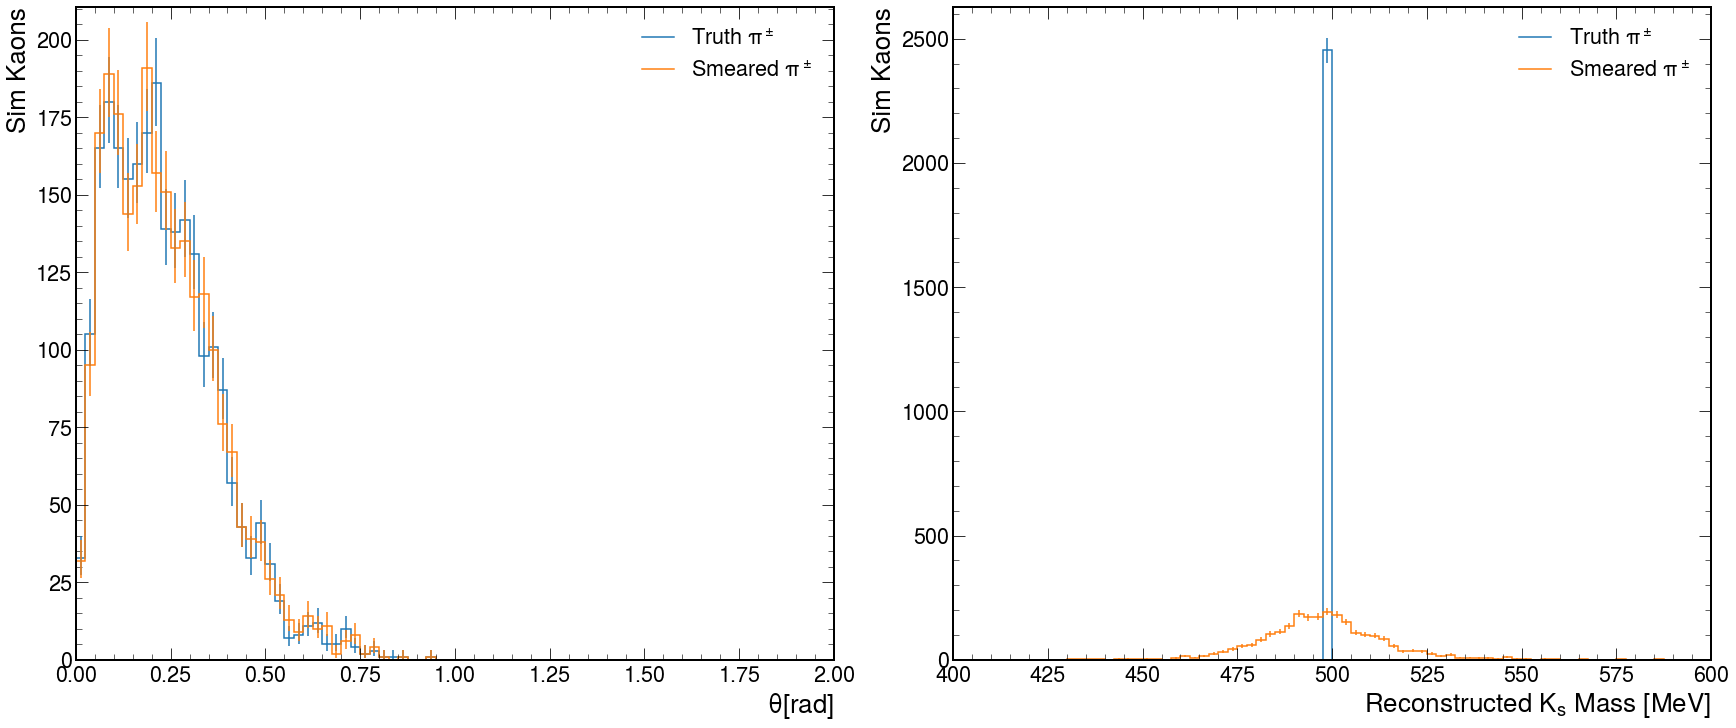

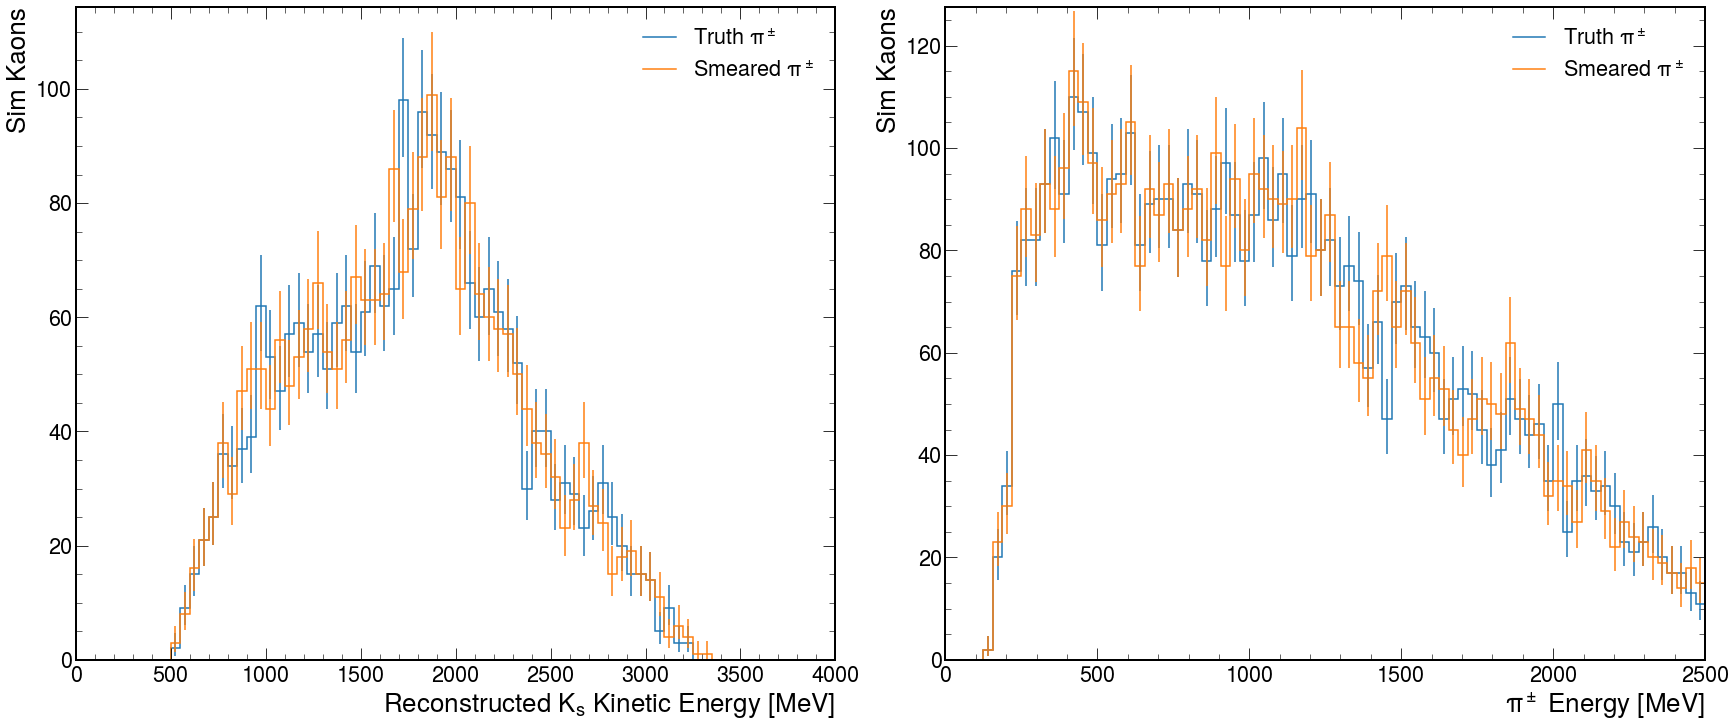

In [8]:
print(hists["sim_pion_theta1"])
fig, ax = plt.subplots(1,2,figsize=(24,10), constrained_layout=True)

hist.plot1d(hists["sim_pion_theta1"],ax=ax[0],clear=False);
hist.plot1d(hists["sim_pion_theta2"],ax=ax[0],clear=False);
leg = ax[0].legend([r'Truth $\pi^\pm$', 'Smeared $\pi^\pm$'])

hist.plot1d(hists["sim_pion_mass1"],ax=ax[1],clear=False);
hist.plot1d(hists["sim_pion_mass2"],ax=ax[1],clear=False);
leg = ax[1].legend([r'Truth $\pi^\pm$', 'Smeared $\pi^\pm$'])



fig, ax = plt.subplots(1,2,figsize=(24,10), constrained_layout=True)

hist.plot1d(hists["sim_pion_sume1"],ax=ax[0],clear=False);
hist.plot1d(hists["sim_pion_sume2"],ax=ax[0],clear=False);
leg = ax[0].legend([r'Truth $\pi^\pm$', 'Smeared $\pi^\pm$'])



hist.plot1d(hists["sim_pion_e1"],ax=ax[1],clear=False);
hist.plot1d(hists["sim_pion_e2"],ax=ax[1],clear=False);
leg = ax[1].legend([r'Truth $\pi^\pm$', 'Smeared $\pi^\pm$'])






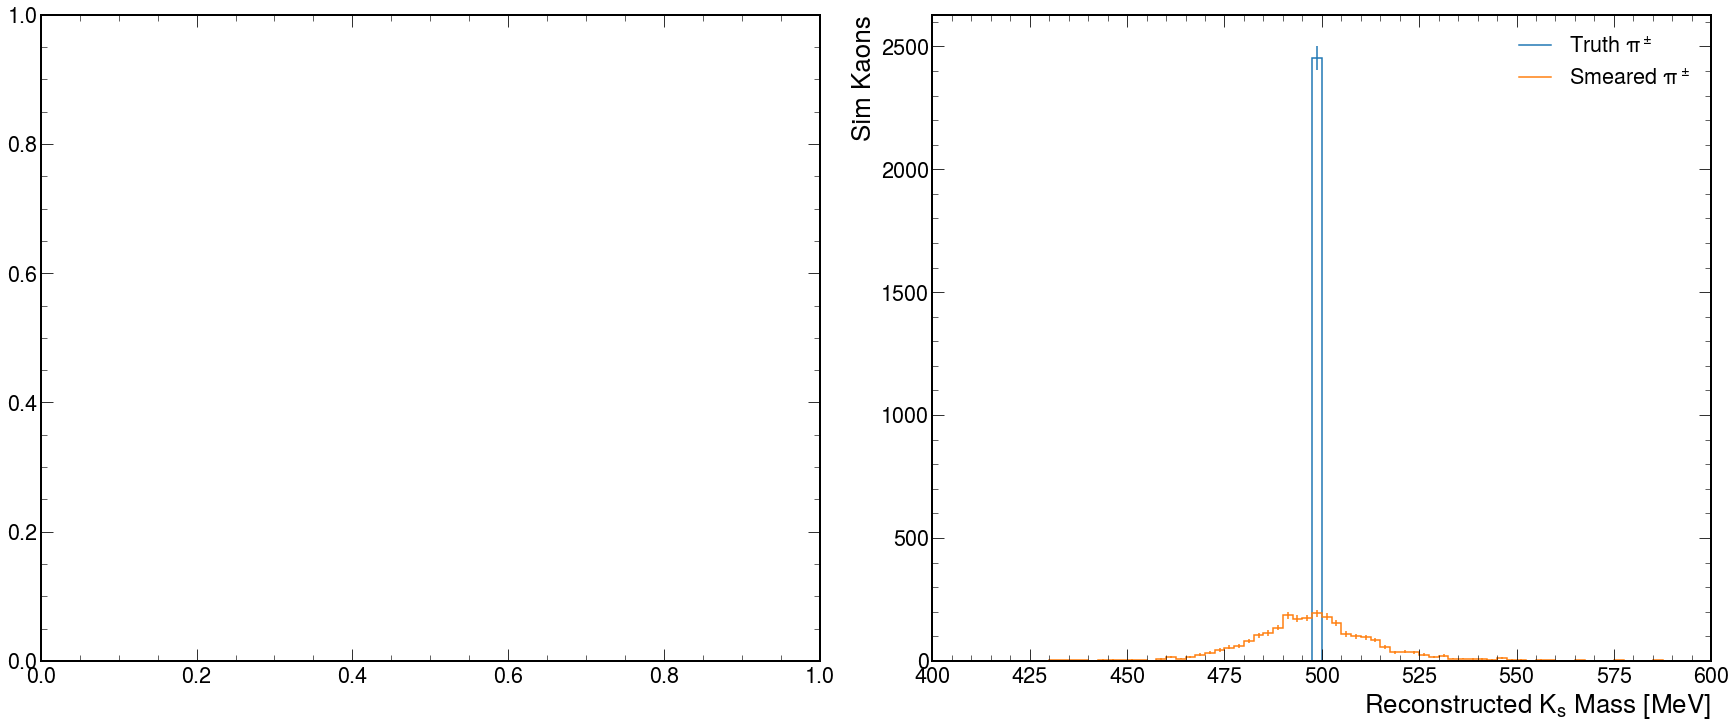

In [9]:
fig, ax = plt.subplots(1,2,figsize=(24,10), constrained_layout=True)

hist.plot1d(hists["sim_pion_mass1"],ax=ax[1],clear=False);
hist.plot1d(hists["sim_pion_mass2"],ax=ax[1],clear=False);
leg = ax[1].legend([r'Truth $\pi^\pm$', 'Smeared $\pi^\pm$'])
